# Questão 1 - Kmeans

In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

## Funções auxiliares

In [ ]:
def normalization_z_score(dataset, mean_values, std_values):
    dataset_copy = dataset.copy()
    dataset_copy = (dataset_copy-mean_values) / std_values
    return dataset_copy, mean_values, std_values

def normalization_min_max(dataset, min_values, max_values):
    dataset_copy = dataset.copy()
    dataset_copy = (dataset_copy-min_values) / (max_values-min_values)
    return dataset_copy, min_values, max_values

def apply_normalization_min_max(dataset, min_values, max_values):
    dataset_copy = dataset.copy()
    dataset_copy = (dataset_copy-min_values) / (max_values-min_values)
    return dataset_copy

def denormalization_z_score(dataset, mean_values, std_values):
    dataset_copy = dataset.copy()
    return (dataset_copy*std_values) + mean_values

def denormalization_min_max(dataset, min_values, max_values):
    dataset_copy = dataset.copy()
    return (dataset_copy*(max_values - min_values)) + min_values

## Leitura e tabulagem dos dados

In [2]:
quake_dataset = np.genfromtxt('quake.csv', delimiter=',', skip_header=0)
min_values = np.min(quake_dataset, axis=0)
max_values = np.max(quake_dataset, axis=0)
quake_dataset, min_values, max_values = normalization_min_max(quake_dataset, min_values, max_values)


In [3]:
df_quake = pd.DataFrame(quake_dataset, columns=["latitude","longitude"])

## Distância Mahalanobis

In [4]:
def covariance_matrix_mahalanobis(data=None, cov=None):
    
    if not cov:
        cov = np.cov(data.values.T)
    inv_cov_mat = np.linalg.inv(cov)
    
    return inv_cov_mat

def distance_matrix_mahalanobis(numpy_dataset, covariance_matrix):
    
    distance_matrix = np.zeros((quake_dataset.shape[0],quake_dataset.shape[0]))
    for i in range(numpy_dataset.shape[0]):
        for j in range(numpy_dataset.shape[0]):
            distance_matrix[i][j] = np.sqrt((numpy_dataset[i]-numpy_dataset[j]).T@covariance_matrix@(numpy_dataset[i]-numpy_dataset[j]))
            
    return distance_matrix

In [5]:
covariance_matrix = covariance_matrix_mahalanobis(data=df_quake[['latitude', 'longitude']])
covariance_matrix

array([[22.84022769, -1.97572607],
       [-1.97572607,  9.33992986]])

In [6]:
class KMeans:
    def __init__(self, cov_matrix, reconstruction_error, db_score, labels):
        self.cov_matrix = cov_matrix
        self.reconstruction_error = reconstruction_error
        self.db_score = db_score
        self.labels = labels
    
    def db_score_calculate(self, distances_json, centroids, distance_function):
        
        db_score = 0
        means = {}
        for each_cluster in distances_json:
            means[each_cluster] = mean(distances_json[each_cluster])
        
        db_score = 0
        
        count = 0
        for each_cluster in means:
            
            max_distance = None
            index_max_cluster = None
            for another_cluster in means:
                if(another_cluster != each_cluster):
                    if(max_distance == None):
                        max_distance = means[another_cluster]
                        index_max_cluster = another_cluster
                    else:
                        if(means[another_cluster] > max_distance):
                            max_distance = means[another_cluster]
                            index_max_cluster = another_cluster
            
            try:
                distance_between_cluster, index = distance_function(centroids[each_cluster,:].reshape(1,2),centroids[index_max_cluster,:].reshape(1,2))
                db_score += (means[each_cluster]+means[index_max_cluster])/distance_between_cluster
                count += 1
            except Exception:
                pass
        
        return db_score/count
        
    
    def euclidian_distance(self, x,y):
        distances = np.sqrt(np.sum(np.power(x-y,2),axis=1, keepdims=True))
        
        return float(np.min(distances)), int(np.argmin(distances))
    
    def mahalanobis_distance(self, x,y):
        min_value = None
        min_index_cluster = None
        x = x.reshape(1,2).T
        
        for each_cluster in range(y.shape[0]):
            this_rows = np.c_[y[each_cluster]]
            if(min_index_cluster == None):
                min_index_cluster = each_cluster
                min_value = np.sqrt((x-this_rows).T@(self.cov_matrix)@(x-this_rows))
            else:
                distance = np.sqrt((x-this_rows).T@(self.cov_matrix)@(x-this_rows))
                if(distance < min_value): 
                    min_value = distance
                    min_index_cluster = each_cluster
        
        return float(min_value), int(min_index_cluster)
        
    def init_centroids_linear(self, X, k_clusters):
        centroids = []
        
        minimuns = np.min(X,axis=0)
        maximuns = np.max(X,axis=0)
        diffs = (maximuns-minimuns)/k_clusters
        
        for each_cluster in range(k_clusters):
            centroids.append(minimuns + diffs*each_cluster)
                
        return np.array(centroids)
    
    def init_centroids_random(self, X, k_clusters):
        
        random_indices = np.random.randint(X.shape[0], size=k_clusters)

        return X[random_indices, :]
    
    
    def update_centroids(self, x, y):
        
        y = np.array(y)
        clusters = np.unique(y)
        new_clusters = np.empty((0,2))
        
        for each_cluster in clusters:
            try:
                new_clusters = np.r_[new_clusters, np.mean(x[y==clusters[each_cluster]], axis=0, keepdims=True)]
            except Exception:
                pass
        
        return new_clusters
        
    def train(self, X, k_clusters = 4, distance="euclidian", centroids_strategy="random", **kwargs):
        
        epochs = 50
        last_distance = 0
        count = 0
        metric_values = []
        
        cov_matrix = None
        
        if(distance == "euclidian"):
            distance_function = self.euclidian_distance
        elif(distance == "mahalanobis"):
            self.cov_matrix = covariance_matrix_mahalanobis(data=df_quake[['latitude', 'longitude']])
            distance_function = self.mahalanobis_distance
        
        if(centroids_strategy == "random"):
            centroids = self.init_centroids_random(quake_dataset, k_clusters)
        elif(centroids_strategy == "linear"):
            centroids = self.init_centroids_linear(quake_dataset, k_clusters)
        
        for each_epoch in range(epochs):
            y_result = []
            distance_sum = 0
            distances_json = {}
            for each_pattern in X:
                distance, cluster = distance_function(each_pattern,centroids)
                if(cluster in distances_json):
                    distances_json[cluster].append(distance)
                else:
                    distances_json[cluster] = [distance]
                y_result.append(cluster)
                distance_sum += distance
            
            centroids = self.update_centroids(X, y_result)
            if(last_distance == 0 or distance_sum < last_distance):
                count = 0
                last_distance = distance_sum
            else:
                if(count > 2):
                    break
                else:
                    count += 1
                    
        self.reconstruction_error = last_distance
        self.labels = np.array(y_result)
        self.db_score = self.db_score_calculate(distances_json, centroids, distance_function)
        
        return None

In [7]:
best_division = None
best_score = None
best_labels = None

for group_number in range(4,21):
    results_db = []
    results_inertia = []
    score_best_inertia = None
    labels_best_inertia = None
    inertia_min = None
    
    for i in range(20):
        kmeans = KMeans(None, None, None, None)
        centroids = kmeans.train(quake_dataset, k_clusters=group_number, centroids_strategy="random")
        db_score = kmeans.db_score
        results_db.append(db_score)
        results_inertia.append(kmeans.reconstruction_error)
        if(inertia_min == None):
            score_best_inertia = db_score
            inertia_min = kmeans.reconstruction_error
            labels_best_inertia = kmeans.labels
        elif(kmeans.reconstruction_error < inertia_min):
            score_best_inertia = db_score if db_score < score_best_inertia else score_best_inertia
            inertia_min = kmeans.reconstruction_error
            labels_best_inertia = kmeans.labels

    if(best_division == None):
        best_division = group_number
        best_score = score_best_inertia
        best_labels = labels_best_inertia
    elif(score_best_inertia < best_score):
        best_division = group_number
        best_score = score_best_inertia
        best_labels = labels_best_inertia
        
    print("Quantidade de grupos: {} Índice DB: {:.2f} +/- {:.4f} e Inércia: {:.2f}".format(str(group_number),mean(results_db),stdev(results_db),mean(results_inertia)))

Quantidade de grupos: 4 Índice DB: 0.67 +/- 0.1013 e Inércia: 308.23
Quantidade de grupos: 5 Índice DB: 0.58 +/- 0.0865 e Inércia: 268.95
Quantidade de grupos: 6 Índice DB: 0.55 +/- 0.0685 e Inércia: 252.09
Quantidade de grupos: 7 Índice DB: 0.48 +/- 0.0881 e Inércia: 216.36
Quantidade de grupos: 8 Índice DB: 0.48 +/- 0.0851 e Inércia: 200.91
Quantidade de grupos: 9 Índice DB: 0.43 +/- 0.0634 e Inércia: 176.30
Quantidade de grupos: 10 Índice DB: 0.41 +/- 0.0700 e Inércia: 164.88
Quantidade de grupos: 11 Índice DB: 0.40 +/- 0.0725 e Inércia: 151.21
Quantidade de grupos: 12 Índice DB: 0.38 +/- 0.0624 e Inércia: 136.38
Quantidade de grupos: 13 Índice DB: 0.41 +/- 0.0753 e Inércia: 135.57
Quantidade de grupos: 14 Índice DB: 0.37 +/- 0.0642 e Inércia: 122.75
Quantidade de grupos: 15 Índice DB: 0.41 +/- 0.0740 e Inércia: 123.75
Quantidade de grupos: 16 Índice DB: 0.43 +/- 0.0555 e Inércia: 112.37
Quantidade de grupos: 17 Índice DB: 0.41 +/- 0.0628 e Inércia: 106.24
Quantidade de grupos: 18 Í

## Distância Euclidiana
### Melhor clustering de tamanho 13 com índice D-B 0.257

17 0.23199596070738457


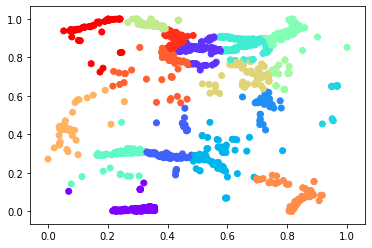

In [8]:
print(best_division, best_score)
plt.scatter(df_quake["latitude"],df_quake["longitude"], c=best_labels, cmap='rainbow')

In [9]:
best_division = None
best_score = None
best_labels = None

for group_number in range(4,21):
    results_db = []
    results_inertia = []
    score_best_inertia = None
    labels_best_inertia = None
    inertia_min = None
    
    for i in range(20):
        kmeans = KMeans(None, None, None, None)
        centroids = kmeans.train(quake_dataset, distance="mahalanobis", k_clusters=group_number)
        db_score = kmeans.db_score
        results_db.append(db_score)
        results_inertia.append(kmeans.reconstruction_error)
        if(inertia_min == None):
            score_best_inertia = db_score
            inertia_min = kmeans.reconstruction_error
            labels_best_inertia = kmeans.labels
        elif(kmeans.reconstruction_error < inertia_min):
            score_best_inertia = db_score if db_score < score_best_inertia else score_best_inertia
            inertia_min = kmeans.reconstruction_error
            labels_best_inertia = kmeans.labels

    if(best_division == None):
        best_division = group_number
        best_score = score_best_inertia
        best_labels = labels_best_inertia
    elif(score_best_inertia < best_score):
        best_division = group_number
        best_score = score_best_inertia
        best_labels = labels_best_inertia
        
    print("Quantidade de grupos: {} Índice DB: {:.2f} +/- {:.4f} e Inércia: {:.2f}".format(str(group_number),mean(results_db),stdev(results_db),mean(results_inertia)))

Quantidade de grupos: 4 Índice DB: 0.56 +/- 0.0255 e Inércia: 1108.41
Quantidade de grupos: 5 Índice DB: 0.54 +/- 0.0426 e Inércia: 1010.12
Quantidade de grupos: 6 Índice DB: 0.50 +/- 0.0455 e Inércia: 921.67
Quantidade de grupos: 7 Índice DB: 0.48 +/- 0.0398 e Inércia: 836.42
Quantidade de grupos: 8 Índice DB: 0.45 +/- 0.0461 e Inércia: 773.95
Quantidade de grupos: 9 Índice DB: 0.43 +/- 0.0334 e Inércia: 703.34
Quantidade de grupos: 10 Índice DB: 0.41 +/- 0.0502 e Inércia: 645.93
Quantidade de grupos: 11 Índice DB: 0.38 +/- 0.0418 e Inércia: 594.23
Quantidade de grupos: 12 Índice DB: 0.36 +/- 0.0534 e Inércia: 546.88
Quantidade de grupos: 13 Índice DB: 0.40 +/- 0.0700 e Inércia: 523.61
Quantidade de grupos: 14 Índice DB: 0.34 +/- 0.0650 e Inércia: 481.31
Quantidade de grupos: 15 Índice DB: 0.34 +/- 0.0511 e Inércia: 470.60
Quantidade de grupos: 16 Índice DB: 0.35 +/- 0.0698 e Inércia: 444.21
Quantidade de grupos: 17 Índice DB: 0.36 +/- 0.0860 e Inércia: 429.59
Quantidade de grupos: 18

## Distância Mahalanobis
### Melhor clustering de tamanho 18 com índice D-B 0.231

20 0.22523274172919588


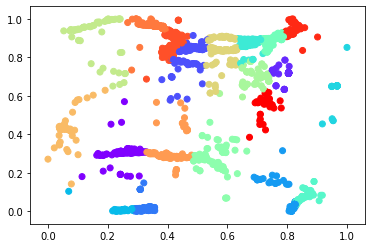

In [10]:
print(best_division, best_score)
plt.scatter(df_quake["latitude"],df_quake["longitude"], c=best_labels, cmap='rainbow')

# Questão 2

In [12]:
penguins_dataset = np.genfromtxt('penguins.csv', delimiter=',', skip_header=0)
min_values = np.min(penguins_dataset, axis=0)
max_values = np.max(penguins_dataset, axis=0)
penguins_dataset_normalized, min_values, max_values = normalization_min_max(penguins_dataset, min_values, max_values)
penguins_dataset_normalized.shape

(333, 5)

In [13]:
class PCA:
    def __init__(self, cov_matrix, projection_matrix, explained_variance, results_components):
        self.projection_matrix = projection_matrix
        self.cov_matrix = cov_matrix
        self.explained_variance = explained_variance
        self.results_components = results_components
    
    def train(self, X, m_size=2, **kwargs):

        self.cov_matrix = np.cov(X.T)
        auto_values, auto_vectors = np.linalg.eigh(self.cov_matrix)
        
        auto_values_indexes = auto_values.argsort()[-m_size:][::-1]
        
        self.projection_matrix = auto_vectors[auto_values_indexes,:]
        self.explained_variance = sum(auto_values[auto_values_indexes])
        
        result_components = np.empty((0,self.projection_matrix.shape[0]))
        
        for each_pattern in X:
            result_components = np.r_[result_components, ((self.projection_matrix@np.c_[each_pattern]).T)]
        
        self.results_components = result_components
        
        return None
    

In [14]:
x_scaled_train = penguins_dataset_normalized[:,:-1]
pca = PCA(None, None, None, None)
pca.train(x_scaled_train, m_size=2)

## item (a

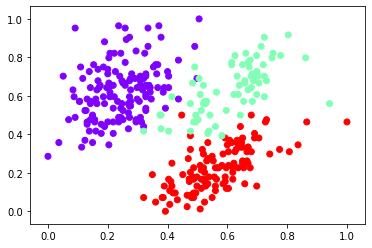

In [15]:
plt.scatter(x_scaled_train[:,[0]],x_scaled_train[:,[1]], c=penguins_dataset[:,[-1]], cmap='rainbow')

## item (b

In [16]:
variance_results = []
for i in range(1,5):
    x_scaled_train = penguins_dataset_normalized[:,:-1]
    pca = PCA(None, None, None, None)
    pca.train(x_scaled_train, m_size=i)
    variance_results.append(pca.explained_variance)

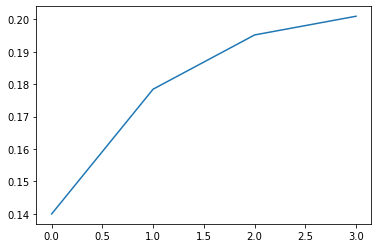

In [17]:
fig = plt.figure()
ax = plt.axes()

ax.plot(variance_results);